# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST

In [2]:
# sklearn can fetch this data set
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# lets look at its structure
print(mnist['DESCR'])
X, y = mnist['data'], mnist['target']
print(X.shape)    # (70000, 784) bc it has 70K images, each 28x28
print(y.shape)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

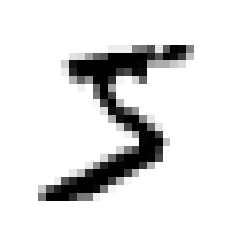

'5'

In [4]:
# lets look at one digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

# to confirm
y[0]    

In [5]:
# notice y[0] is a string --> cast to int
y = y.astype(np.uint8)
y[0]    

5

## Splitting Train / Test

In [6]:
# MNIST comes already split, and training set shuffled for good CV
#.   first 60k = train, last 10k = test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training Binary Classifier

In [7]:
# lets simplify example to just finding whether or not a digit is a 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
# train a Stochastic Gradient Decent Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
# try it out real quick
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [10]:
# many ways to measure performance of a Classifier

## Measuring Accuracy using Cross-Validation

In [11]:
# could implement our own stratified cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# creates folds using stratified sampling
skfolds = StratifiedKFold(n_splits=3)

# iterates through each n_splits folds and creates its own model
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [12]:
# but lets use cross_val_score() anayway
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# these accuracies seem super high!
# but lets check the score of a dumb classifier that always classifies as not-5
from sklearn.base import BaseEstimator

# define dumb classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# test its accuracy
cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [14]:
# Still a high accuracy! This is because only ~10% of data is 5's --> skewed dataset
# this is why accuracy usually isn't the best performance measure for classification

## Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict

# similar to cross_val_score but returns predictions of each fold based on training from all other folds
#.  this is considered 'clean' bc predicts on items that were never used for training
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)   # shape = (60000,)

In [16]:
from sklearn.metrics import confusion_matrix

# make confusion matrix from correct values and CV predictions
confusion_matrix(y_train_5, y_train_pred)

# Output:
# row = actual class, col = predicted class
# [[non-5's predicted non-5,    non-5's predicted 5],
#  [5's predicted non-5,        5's predicted 5]]

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
# perfect model would have a diagonal matrix
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [18]:
from sklearn.metrics import recall_score, precision_score
print(precision_score(y_train_5, y_train_pred))     # percentage of how many classified 5's are actually 5's
print(recall_score(y_train_5, y_train_pred))        # percentage of how many actual 5's are classified as 5's

0.8370879772350012
0.6511713705958311


In [19]:
# F_1 score combines the two together
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


## Precision / Recall Trade-Off

In [20]:
# low threshold  --> high recall, low precision
# high threshold --> low recall, high precision

# sklearn does not let you control threshold, but you can manually get score and use your own threshold
# SGDClassifier uses threshold of 0
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold1 = 0
threshold2 = 2400
print('Regular:', (y_scores > threshold1))
print('Manual: ', (y_scores > threshold2))

[2164.22030239]
Regular: [ True]
Manual:  [False]


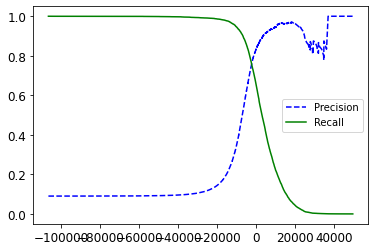

In [21]:
# how to find good threshold:
# sets method='decision_function' so it returns decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

# compute precision and recall for all thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# plot to analyze
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

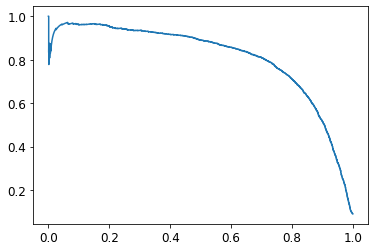

In [22]:
# could also plot precision vs recall
plt.plot(recalls, precisions)
plt.show()

# in this case it would probably make sense to pick a recall before precision drops steeply, say, .6 or so

In [23]:
# could also search for lowest threshold that gives you at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# to use it
y_train_pred_90 = (y_scores >= threshold_90_precision)

# lets check its stats
print('Precision:', precision_score(y_train_5, y_train_pred_90))   # will be just over 0.90
print('Recall:   ', recall_score(y_train_5, y_train_pred_90))      # will be worse bc trade-off

Precision: 0.9000345901072293
Recall:    0.4799852425751706


## The ROC Curve

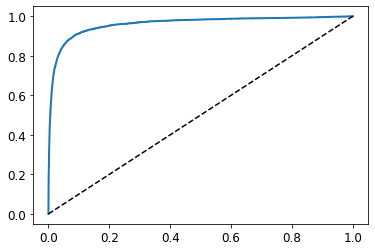

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()
# notice there is still a tradeoff between FPR and TPR
# dotted diagonal = random classifier
# a good classifier stays as far from the line as possible

In [25]:
# can measure by its Area Under the Curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

# notice that this score is really good. Use PR Curve when dealing with smaller positive class (5's)
#.  or when you care more about false positives than false negatives

0.9604938554008616

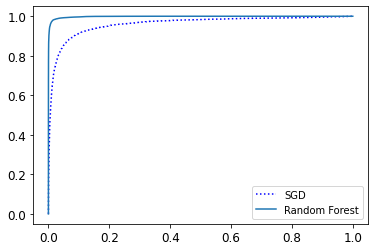

In [26]:
# Now lets make a RandomForest and compare its ROC curve

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# doesn't have decision_function, instead has predict_proba
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

# lets use positive class's probabilities
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [27]:
# better curve means it performs better. means score will also be higher
roc_auc_score(y_train_5, y_scores_forest)

# looking at precision and recall also yield good results!

0.9983436731328145

# Multi-Class Classification

In [28]:
# sklearn automatically makes SVC multi-class via One vs One construction
# 10 labels --> 45 binary SVC's
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)   # y_train NOT y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [29]:
# this will now return scores for each class
some_digit_scores = svm_clf.decision_function([some_digit])

# you'll see that the 5-indexed score is highest --> that is why it predicted 5 above
print(some_digit_scores)

# list of target classes are stored in classes_ attr, ordered by value
print(svm_clf.classes_)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# can also force sklearn to use a particular binary-to-multiclass strategy
from sklearn.multiclass import OneVsRestClassifier # also ahs OneVsOneClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])

In [ ]:
# training a multi-class SGDClassifier (or RandomForest) is just as easy!
# AND it won't do OvO or OvA bc SGD can handle multi-class as-is
sgd_clf.fit(X_train, y_train)    # not y_train_5
sgd_clf.predict([some_digit])

In [35]:
# lets look at the scores --> strong guess of 5, little suspicious of 3
print(sgd_clf.decision_function([some_digit]))

# now lets evaluate this classifier
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))

# get's pretty good scores!

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
[0.87365 0.85835 0.8689 ]


In [ ]:
# can improve the scores a little bit more by standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

# Error Analysis